# Problem Statement:

![title](images/challengebanner.png)

Economies in Southeast Asia are turning to AI to solve traffic congestion, which hinders mobility and economic growth. The first step in the push towards alleviating traffic congestion is to understand travel demand and travel patterns within the city.

 

Can we accurately forecast travel demand based on historical Grab bookings to predict areas and times with high travel demand?

The goal of this project is to **forecast booking demand up to 5 time-steps into the future given geohash and day, time information.** Each time-step is defined as a 15 minute interval.

**Data Columns:**
* geohash6   (encoding of latitude, longitude)
* day        (order of day in the data)
* timestamp  (hour of day and begining minute of 15-min interval)
* demand     (normalized aggregate booking counts in each geohash)

**To predict:**
* Next 5 time-steps given current geohash6,day,timestamp,demand, where each time step is a 15-min interval

**Evaluation metric:**
* RMSE

# Importing Libraries and Data

In [48]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import os
import sys

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from dask.distributed import Client
from sklearn.externals.joblib import parallel_backend
from sklearn.externals import joblib

In [49]:
if not os.path.exists('images'):
    os.mkdir('images')

In [50]:
traffic = pd.read_csv('training.csv')

# Exploring the data 

## Looking at missing values, datatypes, number distributions 

In [51]:
traffic.head()
traffic.info(null_counts=True)
traffic.describe(include='all')

geohash6  day timestamp    demand
0   qp03wc   18      20:0  0.020072
1   qp03pn   10     14:30  0.024721
2   qp09sw    9      6:15  0.102821
3   qp0991   32       5:0  0.088755
4   qp090q   15       4:0  0.074468

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206321 entries, 0 to 4206320
Data columns (total 4 columns):
geohash6     4206321 non-null object
day          4206321 non-null int64
timestamp    4206321 non-null object
demand       4206321 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 128.4+ MB


geohash6           day timestamp        demand
count   4206321  4.206321e+06   4206321  4.206321e+06
unique     1329           NaN        96           NaN
top      qp03wf           NaN       9:0           NaN
freq       5846           NaN     57281           NaN
mean        NaN  3.145299e+01       NaN  1.050907e-01
std         NaN  1.768278e+01       NaN  1.592655e-01
min         NaN  1.000000e+00       NaN  3.092217e-09
25%         NaN  1.600000e+01       NaN  1.867379e-02
50%         NaN  3.200000e+01       NaN  5.043463e-02
75%         NaN  4.700000e+01       NaN  1.208644e-01
max         NaN  6.100000e+01       NaN  1.000000e+00

## Checking for duplicates

In [52]:
any(traffic.duplicated(subset=['geohash6','day','timestamp']))    # no duplication present

False

## Padding timestamp for natural string sorting later 

In [53]:
def pad_timestamp(timestamp):
    timestamp_split = timestamp.str.split(':',expand=True)
    return timestamp_split[0].str.pad(2,fillchar='0') + ":" + timestamp_split[1] 

traffic['timestamp'] = pad_timestamp(traffic['timestamp'])

##  Extent of Geohash variation

In [54]:
geohash_counts = traffic.geohash6.value_counts().sort_index()  # geohash6 varies from 4th digit onwards, all locations within same 156 km-sq
geohash_counts.head()
geohash_counts.tail()

qp02yc    577
qp02yf     89
qp02yu      2
qp02yv      7
qp02yy    106
Name: geohash6, dtype: int64

qp0dn4     224
qp0dn5     334
qp0dnh     181
qp0dnj    1337
qp0dnn     127
Name: geohash6, dtype: int64

## Number of demand data in Time per Geohash

count    1329.000000
mean     3165.027088
std      2032.288462
min         1.000000
25%      1241.000000
50%      3458.000000
75%      5047.000000
max      5846.000000
Name: geohash6, dtype: float64

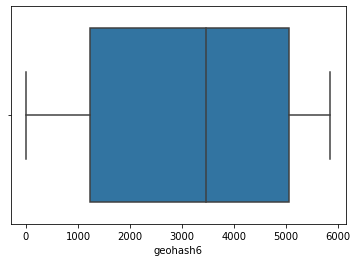

In [55]:
geohash_counts.describe()   
sns.boxplot(geohash_counts)

* 5856 (61 x 24 x 4) day-time available at each geohash, many of them have missing information in time, fill with 0 may improve model 

0.1     135.8
0.2     697.0
0.3    1707.8
0.4    2630.6
0.5    3458.0
0.6    4185.6
0.7    4725.0
0.8    5341.2
0.9    5755.0
Name: geohash6, dtype: float64

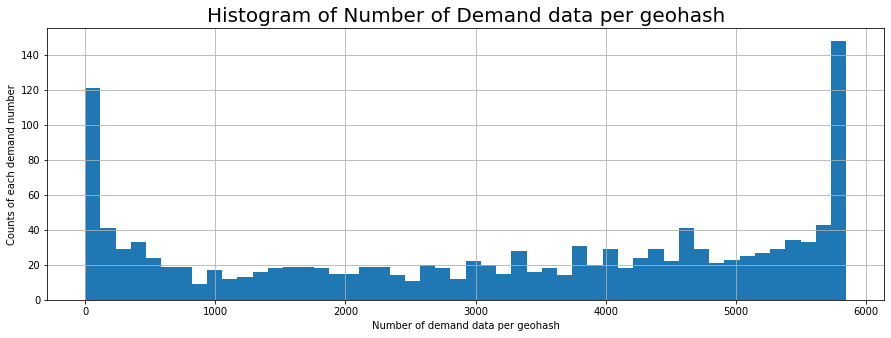

In [56]:
ax = geohash_counts.hist(bins=50,figsize = (15,5))
_ = ax.set_xlabel('Number of demand data per geohash')
_ = ax.set_ylabel('Counts of each demand number')
_ = ax.set_title('Histogram of Number of Demand data per geohash',fontsize=20)

geohash_counts.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

## Number of days of data each geohash contains 

In [57]:
traffic.groupby('geohash6').day.apply(lambda x:len(x.unique()))

geohash6
qp02yc    61
qp02yf    36
qp02yu     2
qp02yv     5
qp02yy    43
qp02yz    61
qp02z1    61
qp02z3    51
qp02z4    60
qp02z5    61
qp02z6    61
qp02z7    61
qp02z9    61
qp02zc    61
qp02zd    61
qp02ze    61
qp02zf    60
qp02zg    61
qp02zh    61
qp02zj    61
qp02zk    61
qp02zm    61
qp02zn    61
qp02zp    61
qp02zq    61
qp02zr    61
qp02zs    61
qp02zt    61
qp02zu    61
qp02zv    61
qp02zw    61
qp02zx    61
qp02zy    61
qp02zz    61
qp03jq    61
qp03jr    61
qp03jw    61
qp03jx    61
qp03jy    61
qp03jz    61
qp03m2    61
qp03m3    61
qp03m6    61
qp03m7    61
qp03m8    61
qp03m9    61
qp03mb    61
qp03mc    61
qp03md    61
qp03me    61
qp03mf    61
qp03mg    61
qp03mk    61
qp03mm    61
qp03mq    61
qp03mr    61
qp03ms    61
qp03mt    61
qp03mu    61
qp03mv    61
qp03mw    61
qp03mx    61
qp03my    61
qp03mz    61
qp03nb    61
qp03nd    61
qp03nf    61
qp03nn    60
qp03np    61
qp03nq    61
qp03nr    61
qp03nw    61
qp03nx    61
qp03ny    61
qp03nz    61
qp03p0    61
qp0

In [58]:
traffic.groupby('geohash6').day.apply(lambda x:len(x.unique())).value_counts().sort_index(ascending=False)

61    1051
60      31
59      19
58      14
57      13
56       7
55      13
54       7
53       5
52       8
51       4
50       5
49       3
48       2
47       2
46       7
45       4
44       2
43       7
42       5
40       2
39       2
38       1
37       4
36       5
34       3
33       3
32       4
31       2
30       3
29       3
28       2
26       1
25       3
23       5
22       3
21       1
20       1
17       3
16       3
15       1
14       3
13       2
11       4
10       4
9        3
8        1
7        4
6        5
5        6
4        6
3        5
2       12
1       10
Name: day, dtype: int64

* Most geohash have all 61 days of data

In [59]:
mask = traffic.groupby('geohash6').day.apply(lambda x:len(x.unique())) < 10 # geohashes with less than 10 days of data

In [60]:
little_geohash = mask[mask].index
len(little_geohash)

52

In [61]:
little_traffic = traffic[traffic.geohash6.isin(little_geohash)]

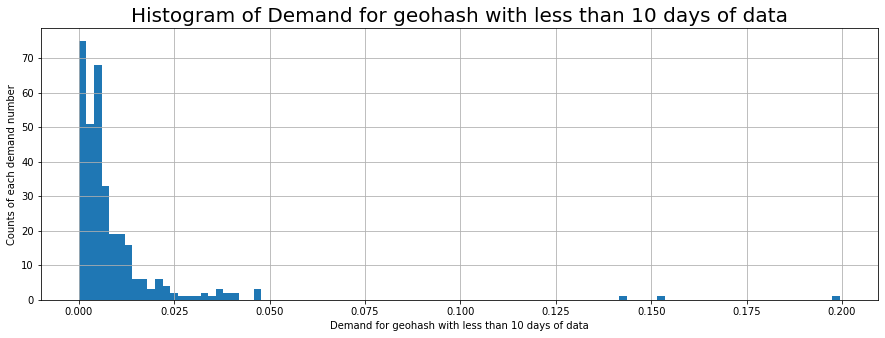

In [62]:
ax = little_traffic.demand.hist(bins=100,figsize = (15,5))
_ = ax.set_xlabel('Demand for geohash with less than 10 days of data')
_ = ax.set_ylabel('Counts of each demand number')
_ = ax.set_title('Histogram of Demand for geohash with less than 10 days of data',fontsize=20)

* Geohashes with lack of demand data mostly have low values in their demand too

In [63]:
traffic.groupby(['geohash6','day']).get_group(('qp02yc',1))

geohash6  day timestamp    demand
1403484   qp02yc    1      12:0  0.003709
1791986   qp02yc    1      04:0  0.006676
2021861   qp02yc    1     11:15  0.013487
2643238   qp02yc    1      03:0  0.010292
2873712   qp02yc    1     02:45  0.020592
3848343   qp02yc    1     06:45  0.011131
4022333   qp02yc    1     04:30  0.003822

## Number of demand data among all Geohashes per Time 

In [64]:
# at any day-time, at most 1073 of 1329 unique geohashes have data, and only 5847 of 5856 possible time slices have demand data
daytime_geohash_size = traffic.groupby(['day','timestamp']).size()     
daytime_geohash_size.describe()

count    5847.000000
mean      719.398153
std       232.240583
min         1.000000
25%       510.500000
50%       821.000000
75%       907.000000
max      1073.000000
dtype: float64

In [65]:
 traffic.groupby(['day','timestamp']).count()

geohash6  demand
day timestamp                  
1   00:0            599     599
    00:15           646     646
    00:30           670     670
    00:45           682     682
    01:0            723     723
    01:15           776     776
    01:30           818     818
    01:45           819     819
    02:0            837     837
    02:15           849     849
    02:30           867     867
    02:45           876     876
    03:0            898     898
    03:15           896     896
    03:30           896     896
    03:45           910     910
    04:0            898     898
    04:15           902     902
    04:30           918     918
    04:45           907     907
    05:0            893     893
    05:15           877     877
    05:30           897     897
    05:45           890     890
    06:0            911     911
    06:15           902     902
    06:30           888     888
    06:45           869     869
    07:0            876     876
    07:15           870     870
    07:30           867     867
    07:45           868     868
    08:0            881     881
    08:15           854     854
    08:30           871     871
    08:45           883     883
    09:0            879     879
    09:15           866     866
    09:30           870     870
    09:45           881     881
    10:0            881     881
    10:15           863     863
    10:30           845     845
    10:45           845     845
    11:0            868     868
    11:15           837     837
    11:30           859     859
    11:45           857     857
    12:0            862     862
    12:15           833     833
    12:30           817     817
    12:45           801     801
    13:0            797     797
    13:15           802     802
    13:30           791     791
    13:45           771     771
    14:0            777     777
    14:15           768     768
    14:30           728     728
    14:45           682     682
    15:0            657     657
    15:15           635     635
    15:30           598     598
    15:45           570     570
    16:0            540     540
    16:15           500     500
    16:30           483     483
    16:45           434     434
    17:0            427     427
    17:15           384     384
    17:30           362     362
    17:45           336     336
    18:0            329     329
    18:15           308     308
    18:30           301     301
    18:45           276     276
    19:0            270     270
    19:15           271     271
    19:30           265     265
    19:45           273     273
    20:0            284     284
    20:15           280     280
    20:30           326     326
    20:45           332     332
    21:0            369     369
    21:15           397     397
    21:30           443     443
    21:45           499     499
    22:0            572     572
    22:15           638     638
    22:30           701     701
    22:45           772     772
    23:0            840     840
    23:15           874     874
    23:30           889     889
    23:45           928     928
2   00:0            926     926
    00:15           929     929
    00:30           940     940
    00:45           953     953
    01:0            928     928
    01:15           932     932
    01:30           939     939
    01:45           930     930
    02:0            934     934
    02:15           911     911
    02:30           911     911
    02:45           907     907
    03:0            923     923
    03:15           935     935
    03:30           921     921
    03:45           926     926
    04:0            920     920
    04:15           934     934
    04:30           942     942
    04:45           918     918
    05:0            904     904
    05:15           929     929
    05:30           910     910
    05:45           915     915
    06:0            921     921
    06:15           920     920
    06:30           919     919
    06:45      

### Number of geohash with demand data per Time

Text(0.5, 0.9, 'Number of geohash with demand data per Day-Hour-Minute')

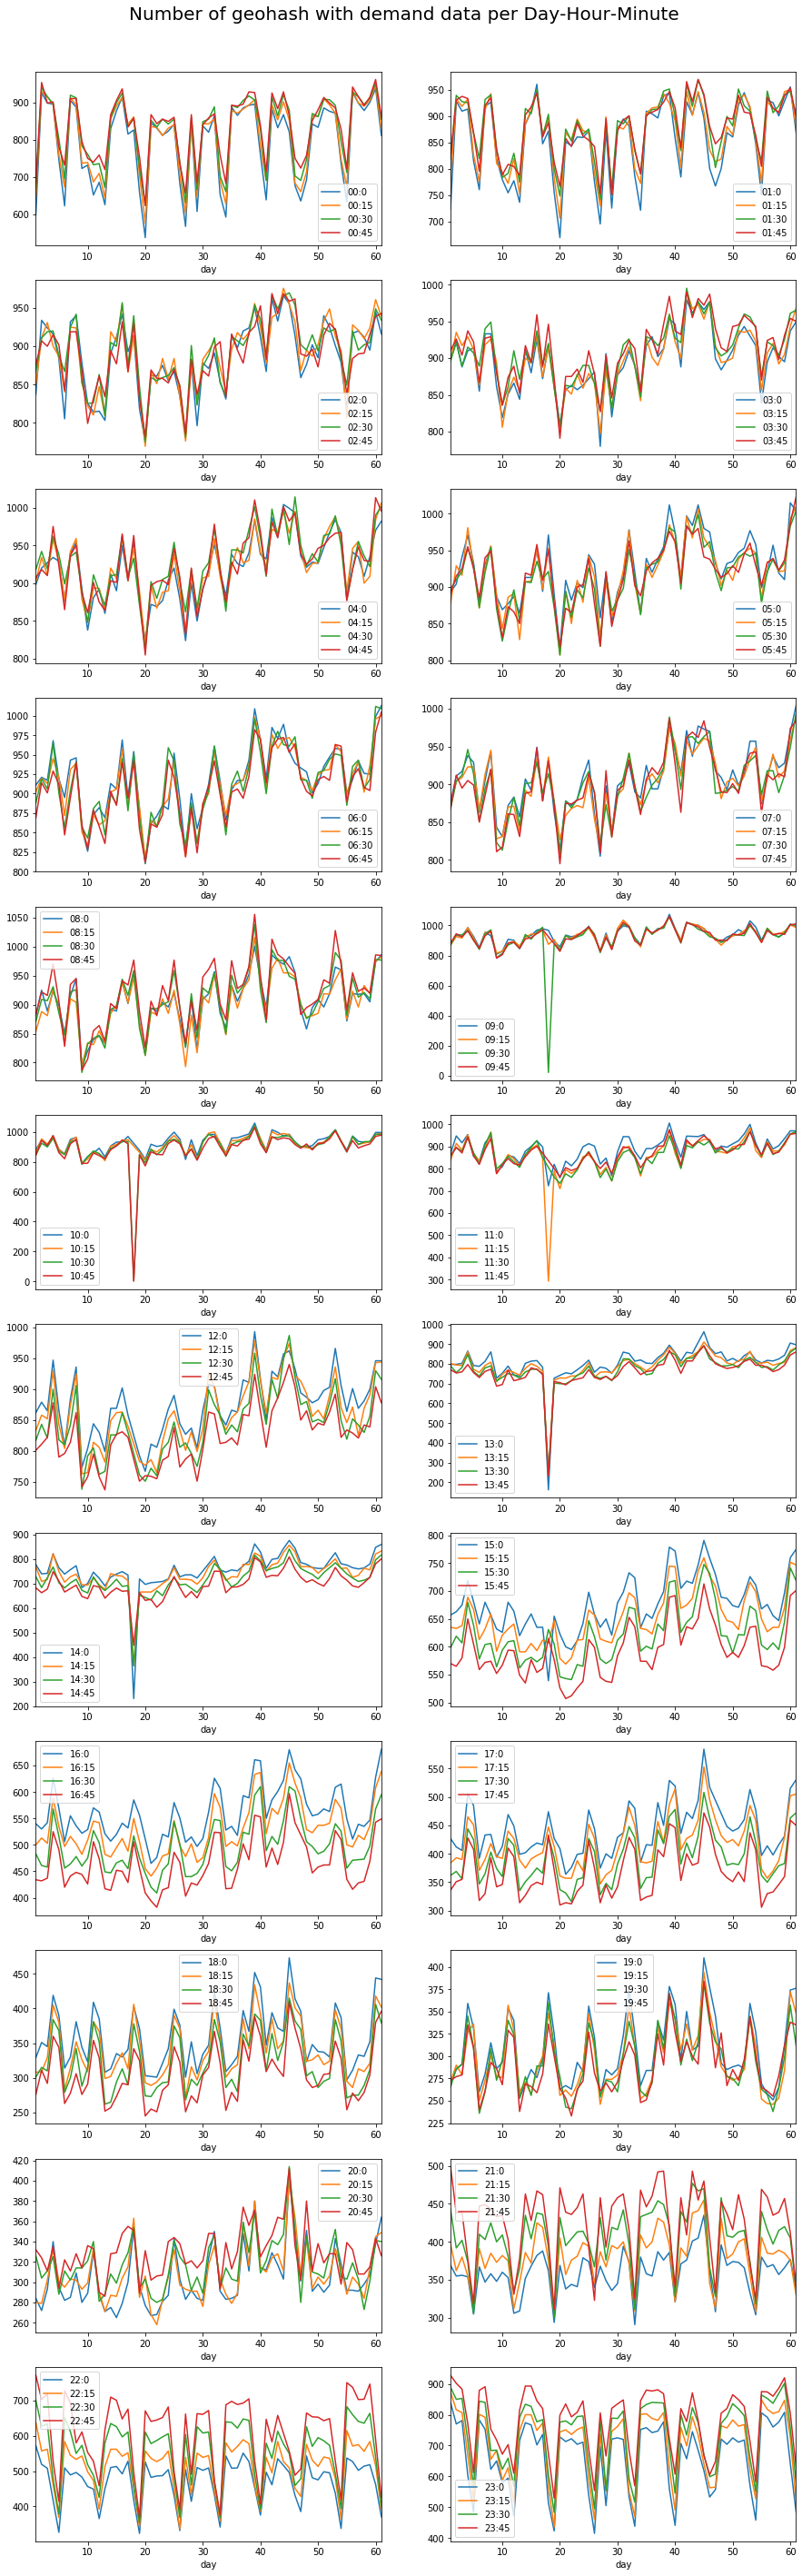

In [66]:
fig,ax = plt.subplots(12,2,figsize=(15,50))
fig.suptitle('Number of geohash with demand data per Day-Hour-Minute', y=0.9, fontsize=20)

hours = [str(x).zfill(2) for x in list(range(24))]
for hour in hours:
    _=daytime_geohash_size[:,"{}:0".format(hour)].plot(label=hour+':0',ax=ax[int(hour)//2,int(hour)%2])
    _=daytime_geohash_size[:,"{}:15".format(hour)].plot(label=hour+':15',ax=ax[int(hour)//2,int(hour)%2])
    _=daytime_geohash_size[:,"{}:30".format(hour)].plot(label=hour+':30',ax=ax[int(hour)//2,int(hour)%2])
    _=daytime_geohash_size[:,"{}:45".format(hour)].plot(label=hour+':45',ax=ax[int(hour)//2,int(hour)%2])
    _=ax[int(hour)//2,int(hour)%2].legend()
    
plt.savefig("images/daytime_geohash_size.png")

In [67]:
daytime_geohash_size[18] # testing if day 18 showing dropping demand

timestamp
00:0     826
00:15    861
00:30    856
00:45    858
01:0     871
01:15    895
01:30    903
01:45    887
02:0     914
02:15    914
02:30    940
02:45    930
03:0     917
03:15    914
03:30    920
03:45    946
04:0     955
04:15    947
04:30    933
04:45    963
05:0     971
05:15    953
05:30    921
05:45    951
06:0     954
06:15    944
06:30    951
06:45    942
07:0     932
07:15    936
07:30    914
07:45    931
08:0     957
08:15    947
08:30    959
08:45    977
09:0     967
09:15    874
09:30     23
10:30      3
10:45      1
11:0     723
11:15    293
13:0     162
13:15    240
13:30    236
13:45    232
14:0     231
14:15    364
14:30    365
14:45    448
15:0     539
15:15    607
15:30    631
15:45    615
16:0     585
16:15    550
16:30    517
16:45    506
17:0     474
17:15    447
17:30    431
17:45    433
18:0     403
18:15    406
18:30    378
18:45    342
19:0     371
19:15    348
19:30    360
19:45    336
20:0     354
20:15    363
20:30    354
20:45    351
21:0     362
21

* Following the graphs in english reading order and lines in order of blue, orange, green, red, we can see the progression of number of geohashes with demand data through time
* We can see the amplitude of the weekly fluctuation across hours based on the range of the y-axis and the number of geohashes with demand from the y-axis values
* The fluctuations increase in intensity from hour 21 to hour 1, seems like there is significant more night activity on weekends in this city 
* Most of the demand from 0:00 to 12:00 have the 4 lines almost overlapping, this shows that overall number of geohashes with demand data within an hour are relatively fixed. 
* From the spacing between the lines, we see demand starts dropping from hour 15, stabilizes at 19 at arond 300 geohashes, then starts increasing until midnight before stabilizing at around 900 geohashes
* We see there are **intermittent huge drops** in overall demand on day 18 compared to neighboring days 17 and 19, from time 9:30 to 14:45. Demand resumes it's weekly pattern from 15:00 onwards. **Are these sensor/network errors?** May fill in with data from other 15-min intervals within same hour.
* The outlying drops may be ignored if we are training only on more recent data, as if we never saw the outliers in time
* The weekly patterns are less pronounced at hours 9,10,11,13,14 because the outliers have widened the y-axis scale.
* Note: This is an aggregation of all geohashes, we cannot conclude whether the demand data always comes from the same set of geohashes (they may be moving across space)

In [68]:
daytime_geohash_size[:,'22:45']   # any hour from 21,22,23 (clearest seasonal pattern) can be used to identify wkday/wkend

day
1     772
2     703
3     719
4     527
5     414
6     728
7     693
8     580
9     611
10    553
11    528
12    458
13    617
14    710
15    701
16    648
17    676
18    496
19    368
20    671
21    641
22    645
23    652
24    682
25    498
26    391
27    662
28    491
29    663
30    661
31    672
32    473
33    376
34    688
35    698
36    689
37    693
38    705
39    528
40    407
41    647
42    583
43    658
44    607
45    556
46    488
47    506
48    665
49    654
50    653
51    643
52    649
53    528
54    417
55    751
56    738
57    703
58    704
59    747
60    589
61    424
dtype: int64

* We see that the days (4,5), (11,12) , (18,19), (25,26) , (32,33), (39,40), (46,47), (53,54), (60,61) have significantly lower number of geohash than other 5 days from seasonal patterns at night times, these are probably the weekends. (Doesn't matter if they really aren't weekends, these 2 day groups could be useful for feature engineering)

0.1    335.0
0.2    435.0
0.3    600.8
0.4    746.0
0.5    821.0
0.6    866.0
0.7    895.2
0.8    919.0
0.9    946.0
dtype: float64

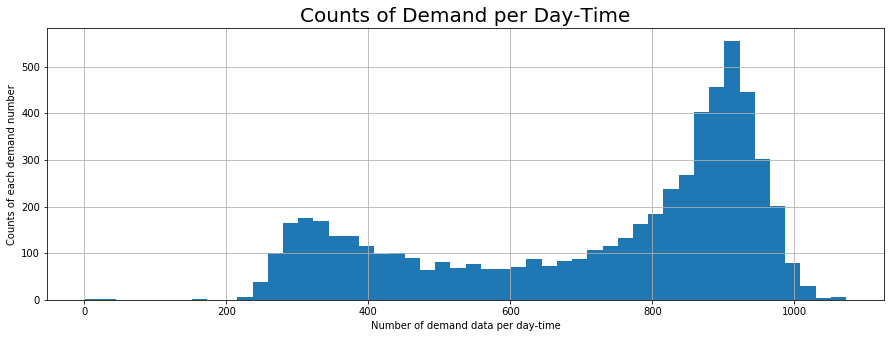

In [69]:
fig = plt.figure(figsize = (15,5))
daytime_geohash_size.hist(bins=50)
_ = plt.xlabel('Number of demand data per day-time')
_ = plt.ylabel('Counts of each demand number')
_ = plt.title('Counts of Demand per Day-Time',fontsize=20)
daytime_geohash_size.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

* We can generally see 2 peaks, one at 900 (hours 1 to 11) and one at 300 (hours 18,19,20)
* The outliers at the bottom could be sensor errors and may need to be replaced with more reasonable values

### Total normalized demand (sum demand in all geohash) per Time  

In [70]:
daytime_demandsum = traffic.groupby(['day','timestamp']).demand.sum()
daytime_demandsum.describe()

count    5847.000000
mean       75.602052
std        42.033189
min         0.002996
25%        32.837224
50%        85.228253
75%       107.470707
max       197.761867
Name: demand, dtype: float64

Text(0.5, 0.9, 'Total normalized demand (sum demand in all geohash) per Day-Hour-Minute')

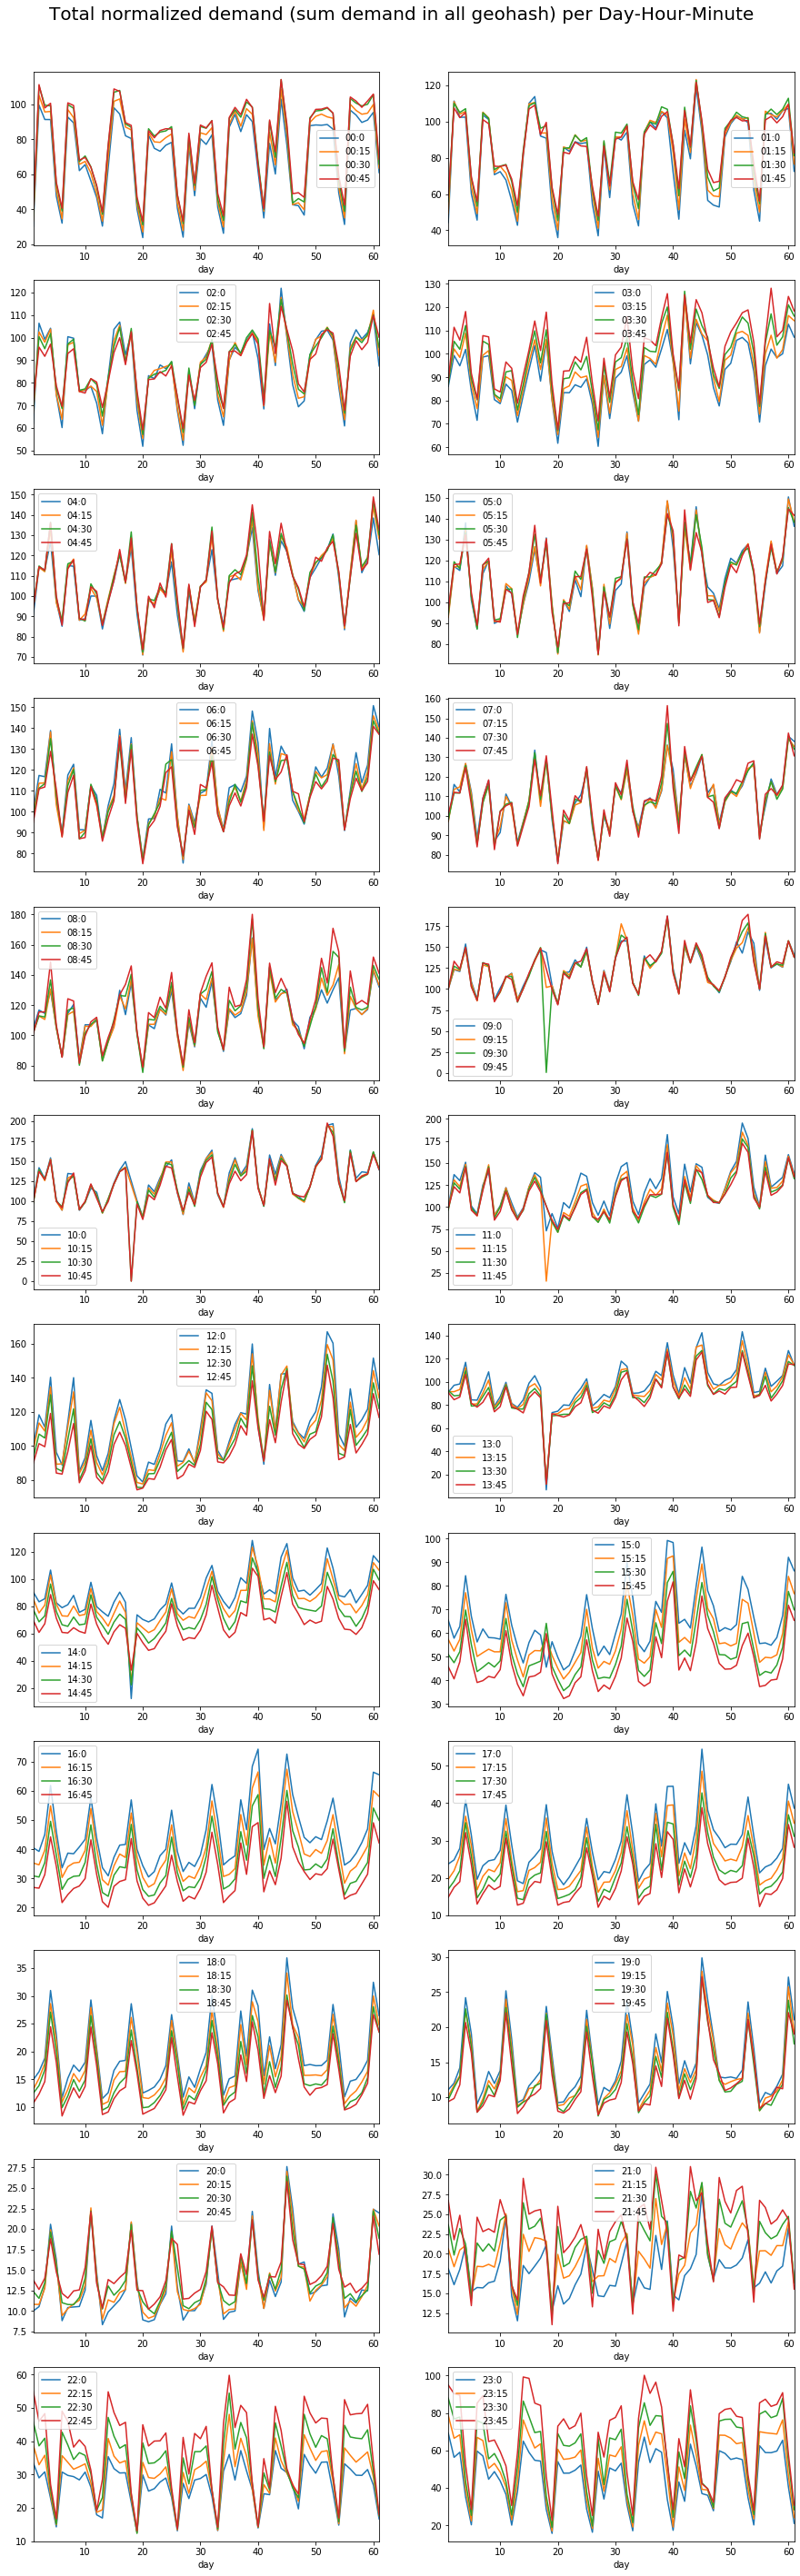

In [71]:
fig,ax = plt.subplots(12,2,figsize=(15,50))
fig.suptitle('Total normalized demand (sum demand in all geohash) per Day-Hour-Minute', y=0.9, fontsize=20)

hours = [str(x).zfill(2) for x in list(range(24))]
for hour in hours:
    _=daytime_demandsum[:,"{}:0".format(hour)].plot(label=hour+':0',ax=ax[int(hour)//2,int(hour)%2])
    _=daytime_demandsum[:,"{}:15".format(hour)].plot(label=hour+':15',ax=ax[int(hour)//2,int(hour)%2])
    _=daytime_demandsum[:,"{}:30".format(hour)].plot(label=hour+':30',ax=ax[int(hour)//2,int(hour)%2])
    _=daytime_demandsum[:,"{}:45".format(hour)].plot(label=hour+':45',ax=ax[int(hour)//2,int(hour)%2])
    _=ax[int(hour)//2,int(hour)%2].legend()
    
plt.savefig("images/daytime_demandsum.png")

* The total normalized demand plots look very similar to the Number of Geohash with demand data per Time plot above, main difference being the y-axis value and what it represents
* The total normalized demand starts dropping from hour 12 to hour 20 (15 total demand) before surging from hour 21 to hour 23 (80 total demand), then gradually increasing to 200 total demand until the next day's hour 12. This shows that demand is high from night until early afternoon. Interersting to note that geohash counts stablize at around 900 around midnight but the total normalized demand continues to grow from 80 to 200 until the next afternoon


0.1     15.761335
0.2     25.231271
0.3     42.700031
0.4     68.573009
0.5     85.228253
0.6     94.615101
0.7    102.876479
0.8    112.172020
0.9    126.720750
Name: demand, dtype: float64

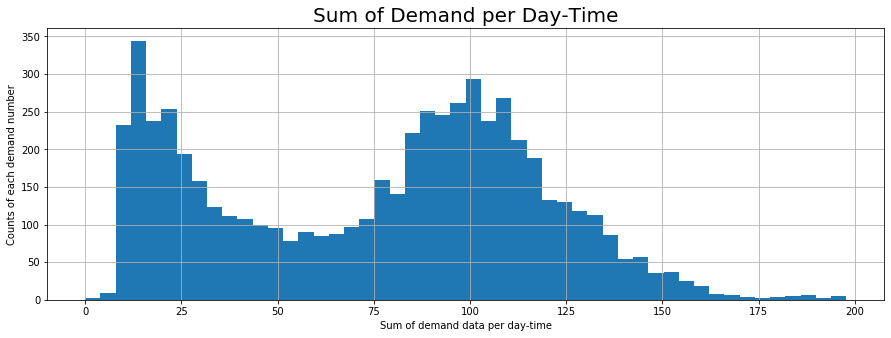

In [72]:
fig = plt.figure(figsize = (15,5))
daytime_demandsum.hist(bins=50)
_ = plt.xlabel('Sum of demand data per day-time')
_ = plt.ylabel('Counts of each demand number')
_ = plt.title('Sum of Demand per Day-Time',fontsize=20)
daytime_demandsum.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

###  Mean (of all geohash) normalized demand per Time

In [73]:
daytime_demandmean = traffic.groupby(['day','timestamp']).demand.mean()
daytime_demandmean.describe()

count    5847.000000
mean        0.095331
std         0.033863
min         0.002996
25%         0.064305
50%         0.102396
75%         0.120339
max         0.207298
Name: demand, dtype: float64

Text(0.5, 0.9, 'Mean normalized demand (mean demand of all geohash) per Day-Hour-Minute')

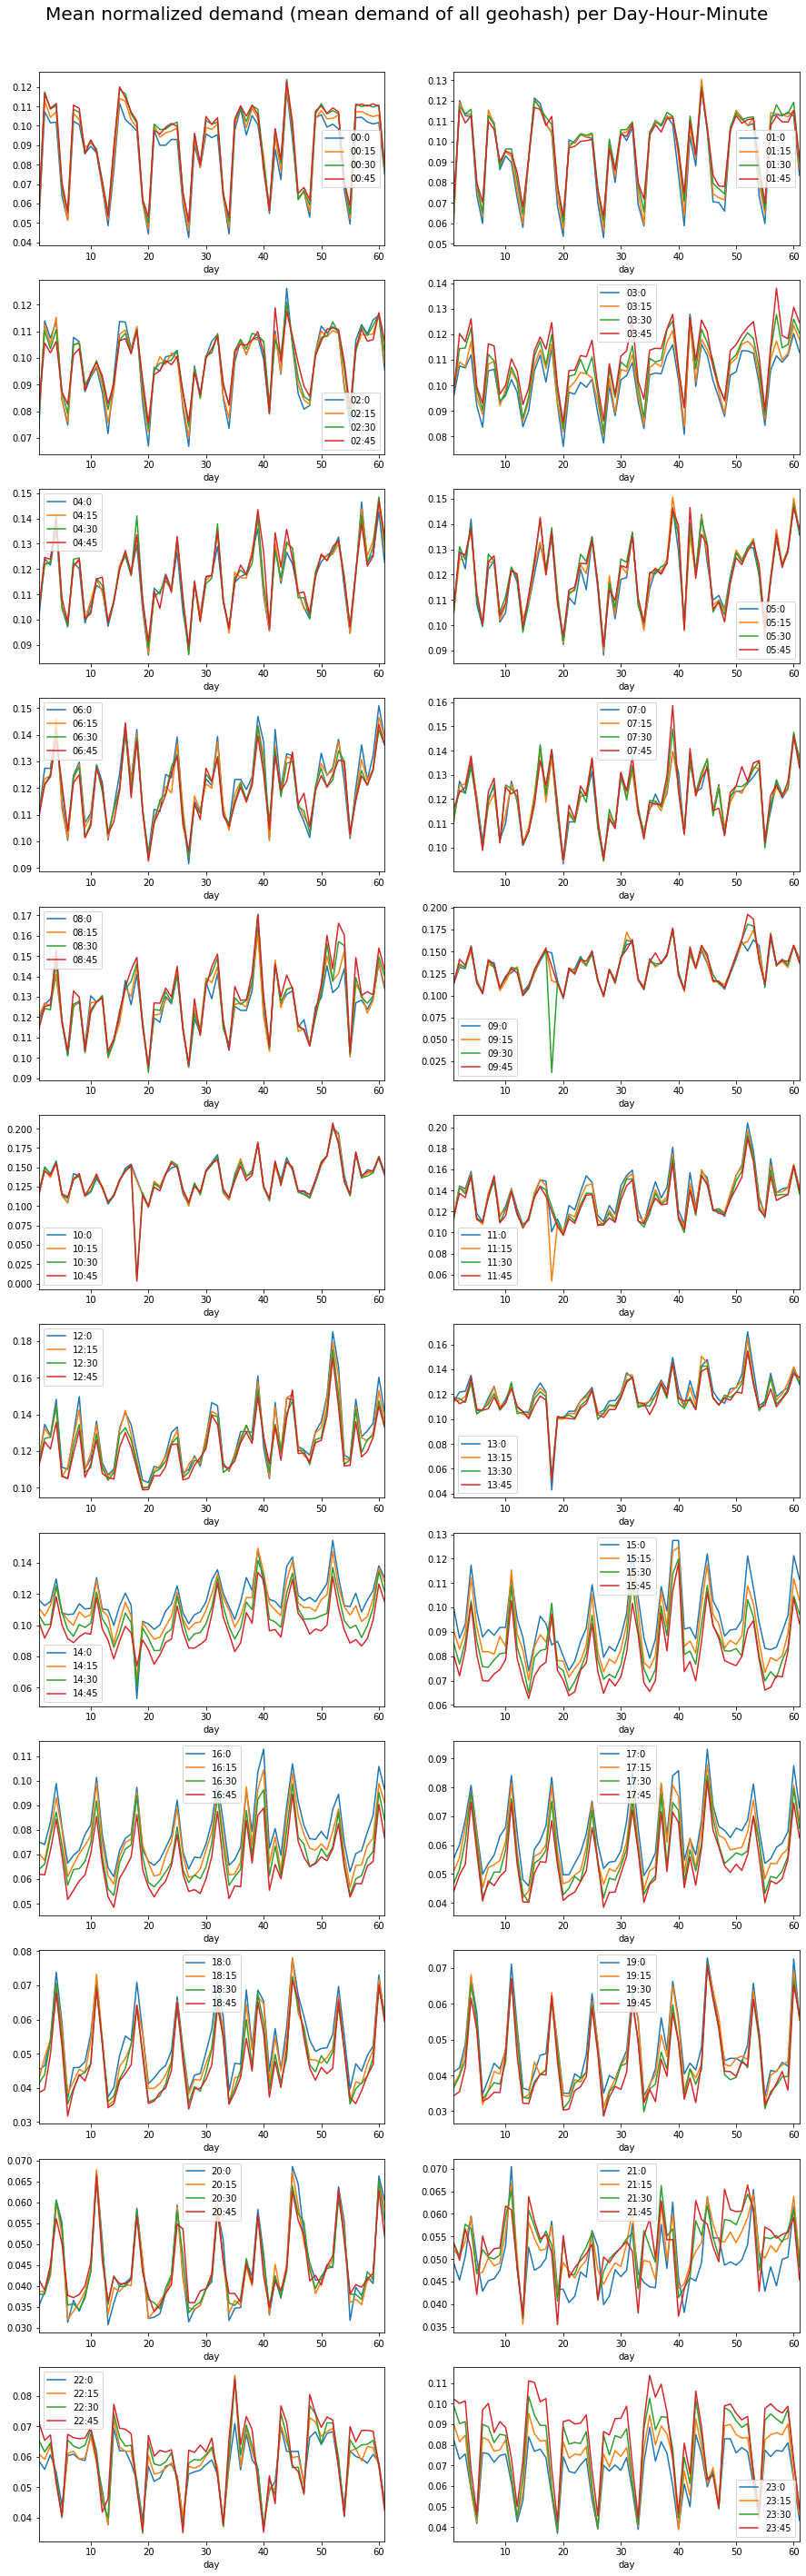

In [74]:
fig,ax = plt.subplots(12,2,figsize=(15,50))
fig.suptitle('Mean normalized demand (mean demand of all geohash) per Day-Hour-Minute', y=0.9, fontsize=20)

hours = [str(x).zfill(2) for x in list(range(24))]
for hour in hours:
    _=daytime_demandmean[:,"{}:0".format(hour)].plot(label=hour+':0',ax=ax[int(hour)//2,int(hour)%2])
    _=daytime_demandmean[:,"{}:15".format(hour)].plot(label=hour+':15',ax=ax[int(hour)//2,int(hour)%2])
    _=daytime_demandmean[:,"{}:30".format(hour)].plot(label=hour+':30',ax=ax[int(hour)//2,int(hour)%2])
    _=daytime_demandmean[:,"{}:45".format(hour)].plot(label=hour+':45',ax=ax[int(hour)//2,int(hour)%2])
    _=ax[int(hour)//2,int(hour)%2].legend()


plt.savefig("images/daytime_demandmean.png")

* The information conveyed in this plot is largely the same as the `Total normalized demand per time` plot above  

0.1    0.046420
0.2    0.058234
0.3    0.071572
0.4    0.090123
0.5    0.102396
0.6    0.109714
0.7    0.116545
0.8    0.124689
0.9    0.136108
Name: demand, dtype: float64

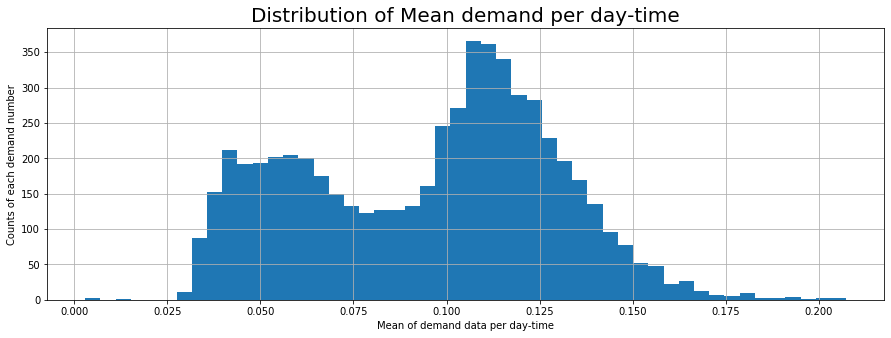

In [75]:
fig = plt.figure(figsize = (15,5))
daytime_demandmean.hist(bins=50)
_ = plt.xlabel('Mean of demand data per day-time')
_ = plt.ylabel('Counts of each demand number')
_ = plt.title('Distribution of Mean demand per day-time',fontsize=20)
daytime_demandmean.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

### Day-Interval mean demand map

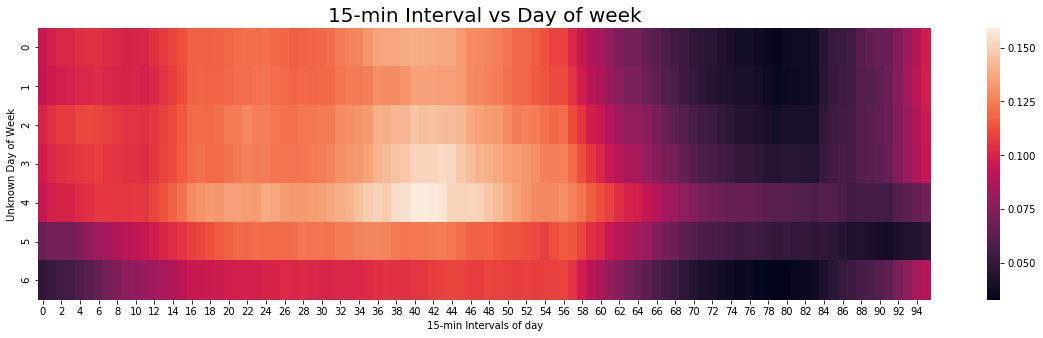

In [76]:
def time_indexers(df):
    day_of_week = (df.day%7).rename('day_week')
    timestamp_split = df['timestamp'].str.split(':',expand=True).rename(columns = {0:'hour',1:'min'})
    hour_of_day = timestamp_split['hour'].astype('int').rename('hour_day')
    min_of_hour = timestamp_split['min'].astype('int').rename('min_hour')
    
    return day_of_week, hour_of_day, min_of_hour

day_of_week, hour_of_day, min_of_hour = time_indexers(traffic)
frac_hour = ((min_of_hour+15)/60).rename('frac_hour')


day_hour_int_df = pd.concat([day_of_week,hour_of_day,frac_hour,traffic.demand],axis=1)
day_hour_frac_mean_map = day_hour_int_df.groupby(['day_week','hour_day','frac_hour']).demand.mean()
del day_hour_int_df 

fig, ax = plt.subplots(figsize=(20,5)) 
_ = sns.heatmap(day_hour_frac_mean_map.values.reshape(7,24*4),ax=ax)
_ = ax.set_xlabel('15-min Intervals of day')
_ = ax.set_ylabel('Unknown Day of Week')
_ = ax.set_title('15-min Interval vs Day of week',fontsize=20)
plt.savefig("images/15-min_Interval_vs_Day_of_week.png")

* It is more difficult to see the surging total normalized demand from hour 21 to 23 seen previously from this map because this is a mean demand that took into account the increased number of geohashes with demand data too.
* This plot agrees with the above plots that dow 4,5 have very low demand at night (seen from hour 23 here).

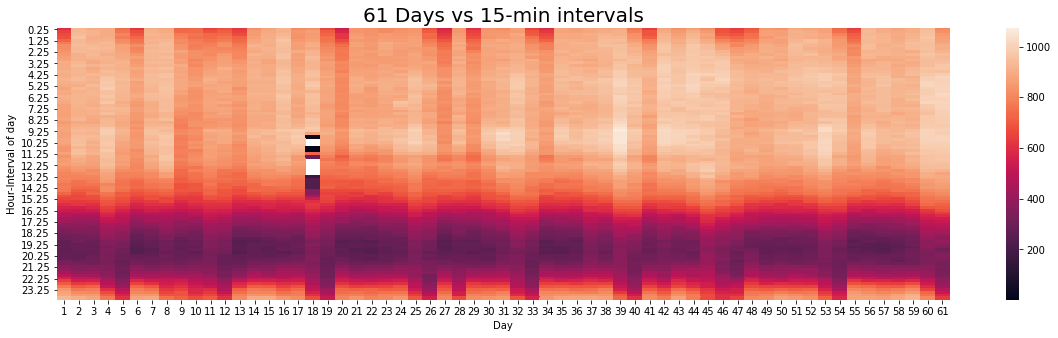

In [77]:
allday_intervals = pd.concat([traffic['day'],(hour_of_day+frac_hour).rename('interval'),traffic['demand']],axis=1)

fullmap = allday_intervals.groupby(['day','interval']).demand.count().unstack()
del allday_intervals

fig, ax = plt.subplots(figsize=(20,5)) 
_ = sns.heatmap(fullmap.T,ax=ax)
_ = ax.set_xlabel('Day')
_ = ax.set_ylabel('Hour-Interval of day')
_ = ax.set_title('61 Days vs 15-min intervals',fontsize=20)
plt.savefig("images/61_Days_vs_15-min_intervals.png")

* This heatmap of all seen days in data vs all seen intervals in data show that there is missing data on data 18 at previously identified time intervals, confirming the above line plots. This day can be left out for model training to save data imputation time, and start from day 19 since the weekly patterns are strong and not too much information should be lost ignoring day 18. 

## Demand distribution in Total (without space or time slice) 

count    4.206321e+06
mean     1.050907e-01
std      1.592655e-01
min      3.092217e-09
25%      1.867379e-02
50%      5.043463e-02
75%      1.208644e-01
max      1.000000e+00
Name: demand, dtype: float64

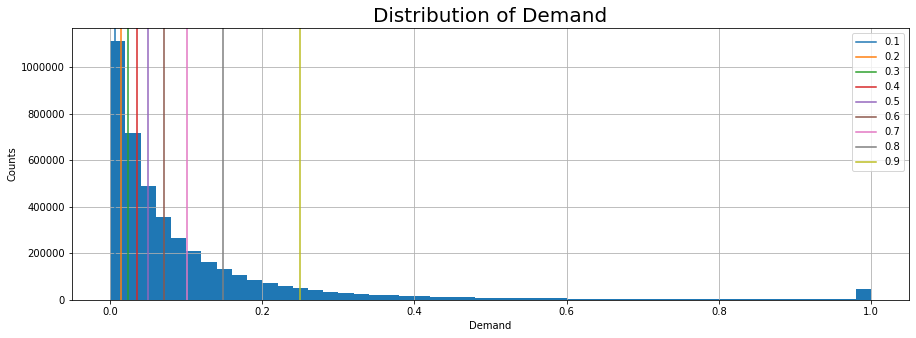

In [78]:
traffic.demand.describe()

fig = plt.figure(figsize = (15,5))
traffic.demand.hist(bins=50)   # highly skewed, smallest demand only 10^-9
_ = plt.xlabel('Demand')
_ = plt.ylabel('Counts')
_ = plt.title('Distribution of Demand',fontsize=20)

percentiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,]
xcoords = traffic.demand.quantile(percentiles)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for percentile,color,xc in zip(percentiles,colors,xcoords):
    _ = plt.axvline(x=xc,c=color,label=percentile)
    
plt.legend()

* The bottom 90 percentile have normalized demand values less than 0.25, very few demand values are above 0.25
* The distribution may change if analyzed by time or space
* It may be wise to ignore the geohashes with very little normalized demand and focus on getting the model to be more accurate on the geohashes with higher demand when using a performance metric taking into consideration error on all geohashes 

In [79]:
traffic.demand.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
traffic.demand.value_counts().sort_index().head()

0.1    0.006512
0.2    0.014217
0.3    0.023617
0.4    0.035272
0.5    0.050435
0.6    0.070951
0.7    0.100481
0.8    0.147911
0.9    0.249284
Name: demand, dtype: float64

3.092217e-09    1
2.500851e-08    1
3.042696e-08    1
4.427836e-08    1
4.797226e-08    1
Name: demand, dtype: int64

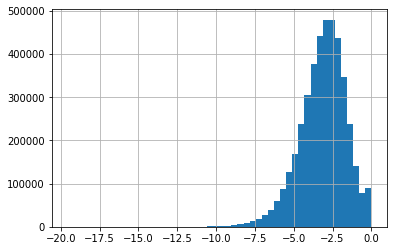

In [80]:
np.log(traffic.demand).hist(bins=50)   # could be a useful transformation for the model, boxcox is an option too

# Decoding geohash and checking bounds of latitude, longitude  

In [81]:
import geohash as gh

unique_geohash = traffic.geohash6.unique()
geohashes = pd.Series(unique_geohash).apply(gh.decode)   # 30 seconds decoding
latitude, longitude = zip(*geohashes)

print(f'Min Latitude: {min(latitude)}\nMax Latitude: {max(latitude)}\nMin Longitude: {min(longitude)}\nMax Longitude: {max(longitude)}')

geohash_latlon = pd.concat([pd.Series(unique_geohash,name='geohash6'),pd.Series(latitude,name='latitude'),pd.Series(longitude,name='longitude')],axis=1)

le = LabelEncoder()
geohash_latlon['geo_encoded'] = le.fit_transform(geohash_latlon['geohash6'])

if not os.path.exists('processed_data'):
    os.mkdir('processed_data')
#geohash_latlon.to_csv('processed_data/geohash_latlon.csv',index=False)

Min Latitude: -5.48492431640625
Max Latitude: -5.23773193359375
Min Longitude: 90.5877685546875
Max Longitude: 90.9722900390625


In [82]:
geohash_latlon.head()

geohash6  latitude  longitude  geo_encoded
0   qp03wc -5.353088  90.653687          212
1   qp03pn -5.413513  90.664673           94
2   qp09sw -5.325623  90.906372         1056
3   qp0991 -5.353088  90.752563          703
4   qp090q -5.413513  90.719604          460

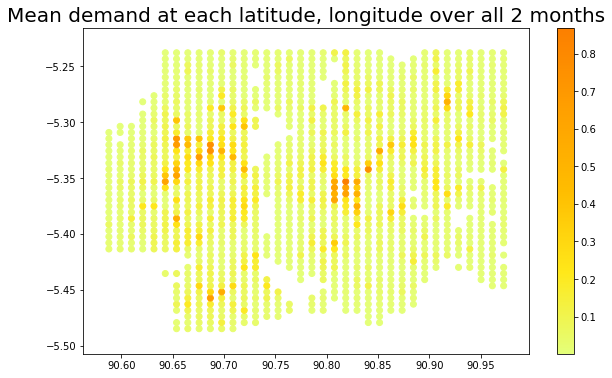

In [83]:
geo_mean_demand = traffic.groupby(['geohash6'],as_index=False).demand.mean()
latlon_mean_demand = geo_mean_demand.merge(geohash_latlon)

fig,ax = plt.subplots(figsize=(10,6))
ax = plt.scatter(latlon_mean_demand.longitude,latlon_mean_demand.latitude,c=latlon_mean_demand.demand,cmap='Wistia')
_ = plt.colorbar(ax)
_ =plt.title("Mean demand at each latitude, longitude over all 2 months",fontsize=20)

* We can see 2 main clusters of relatively higher mean demand in this rectangle

## Heatmaps by Day

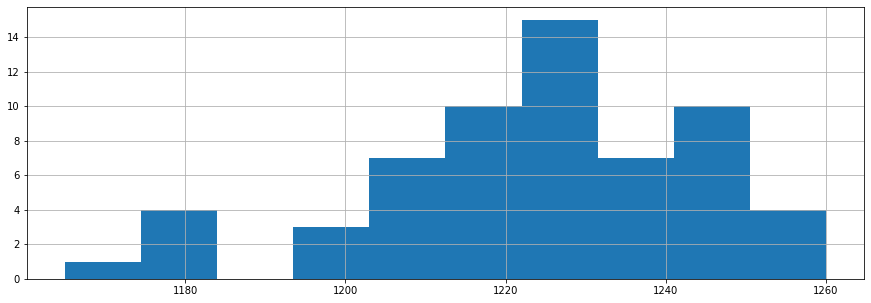

In [84]:
geo_day_mean_demand = traffic.groupby(['geohash6','day']).demand.mean()
geohash_per_day = []
for i in range(1,62):
    geohash_per_day.append(len(geo_day_mean_demand[:,i]))

fig = plt.figure(figsize = (15,5))
pd.Series(geohash_per_day).hist()  

* All days have more than 1100 geohashes with data. We need to zoom further into the hour and 15-min interval level to really see where are the areas with missing data

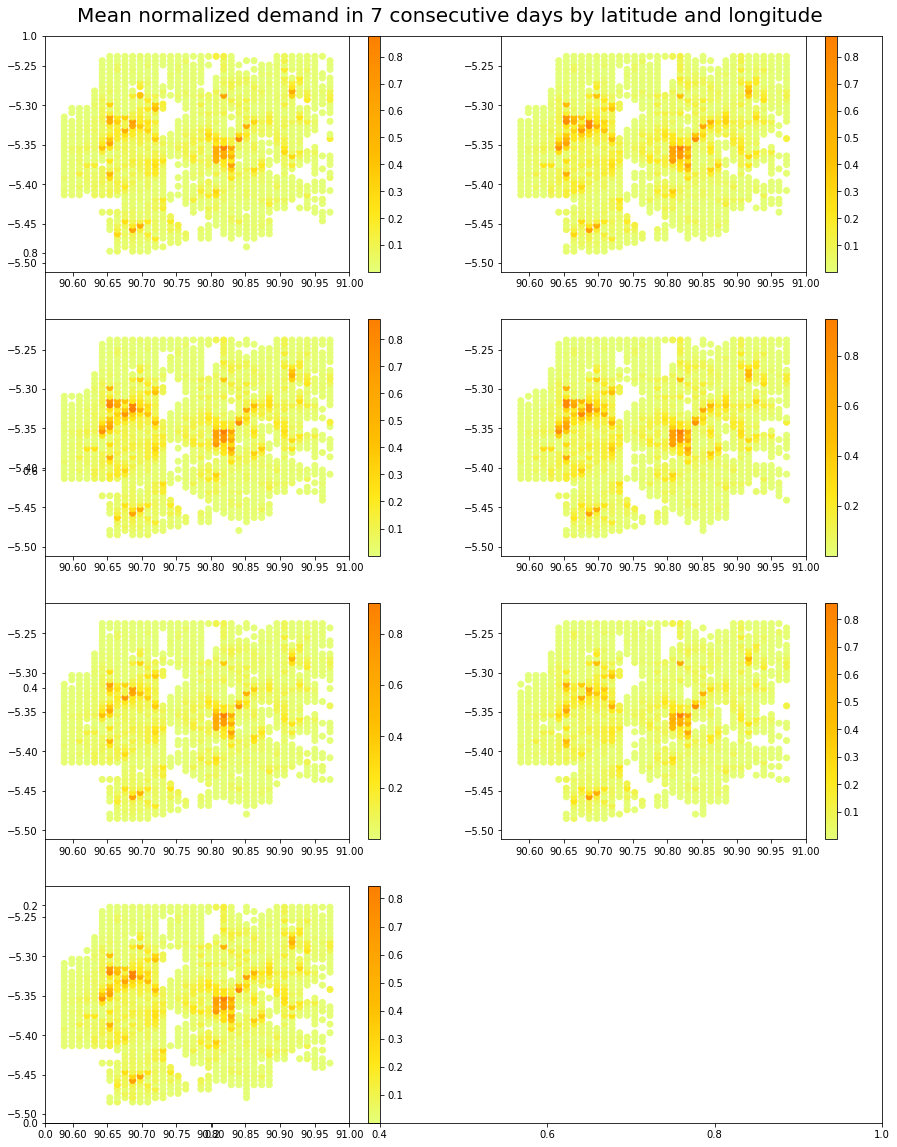

In [85]:
fig,ax = plt.subplots(figsize=(15,20))
_ = fig.suptitle('Mean normalized demand in 7 consecutive days by latitude and longitude', y=0.9, fontsize=20)
i = 1
k = 0   # increment to move plots forward by 1 week
for day in range(1+k*7,8+k*7):
    axs = fig.add_subplot(4,2,i)
    latlon_day_mean_demand = geo_day_mean_demand[:,day].reset_index().merge(geohash_latlon)
    map = axs.scatter(latlon_day_mean_demand.longitude,latlon_day_mean_demand.latitude,c=latlon_day_mean_demand.demand,cmap='Wistia')
    _=plt.colorbar(map,ax=axs)
    i+=1
del geo_day_mean_demand

* The mean demand heatmap differences between the 1st 7 days is almost indiscernable except for different geohashes having no data. 
* What we do confirm is hotspots are not shifting much day by day, these hotspots could be used as the centre points of gaussian mixture models
* These fixed hotspots in time also make selecting time periods for generating spatial features easier  
* For predictions, an average prediction by geohash, then day, then hour, then 15-min interval patterns in a step-wise fashion like gradient boosting could be useful
* If there was a model sensitive to picture intensities, we can apply next-picture prediction models trained on video made of timesliced heatmaps to generate a prediction not just for 1 geohash in each future time step but the whole map --> Try if time permits 

# Data Cleaning
* We may want to filling in missing index and values to form a complete picture and provide convenience for future data manipulation -->`traffic_full` 

In [86]:
geohash_unique = traffic.geohash6.unique()
day_unique = traffic.day.unique()
timestamp_unique = traffic.timestamp.unique()

multi_all = pd.MultiIndex.from_product([geohash_unique,day_unique,timestamp_unique],names=['geohash6','day','timestamp'])

multi_index_df = traffic.set_index(['geohash6','day','timestamp'])

traffic_full = multi_index_df.reindex(multi_all,fill_value=np.nan)    # fill 0 during EDA not good, hides information from groupby later 
traffic_full = traffic_full.reset_index()

del multi_all,multi_index_df

In [87]:
def fill_df(df,value = 0):
    return df.fillna(value)

traffic_full_zero = fill_df(traffic_full).sort_values(['geohash6','day','timestamp'])    
#traffic_full_zero.to_csv('processed_data/traffic_full_zero.csv', index=False)
del traffic_full

* Filling with 0 may not be the best way, using spatio-temporal neighbors could be more accurate in accounting for sensor errors at certain geohash-time pairs

# Feature Engineering

* The strategy here is saving historical information from the training data for joining to the prediction data

### Characterizing demand per geohash 

In [88]:
def activity_frac(group):
    """Fraction of all time periods a geohash has demand data
    For use in groupby.agg in demand_history() to provide a column name"""
    return len(group)/(61*24*4)

def demand_history(df):
    geo_stats = df.groupby(['geohash6']).agg({'demand':['mean','median','max','min','std','skew',activity_frac]})
    geo_stats.columns = ['_geohash_'.join(column) for column in geo_stats.columns.ravel()]
    geo_stats.demand_geohash_std.fillna(0,inplace=True)
    geo_stats.demand_geohash_skew.fillna(0,inplace=True)
    
    return geo_stats.reset_index()

geo_stats = demand_history(traffic)
#geo_stats.to_csv('processed_data/geo_stats.csv',index=False)

### Characterizing demand per time unit 

In [89]:
def geohash_frac(group):
    """
    Fraction of all geohashes a time slice has data
    For use in groupby.agg in time_history() to provide a column name
    """
    return len(group)/1329   #1329 unique geohashes under this study

def time_indexers(df):
    """
    Extract integer hour and minute from timestamp and generate day of week
    """
    day_of_week = (df.day%7).rename('day_week')
    timestamp_split = df['timestamp'].str.split(':',expand=True).rename(columns = {0:'hour',1:'min'})
    hour_of_day = timestamp_split['hour'].astype('int').rename('hour_day')
    min_of_hour = timestamp_split['min'].astype('int').rename('min_hour')
    
    return day_of_week, hour_of_day, min_of_hour

def time_history(df):
    print(df.head())
    day_of_week, hour_of_day, min_of_hour = time_indexers(df)

    time_stats = df.groupby([day_of_week,hour_of_day,min_of_hour]).agg({'demand':['mean','median','max','min','std','skew',geohash_frac]})
    time_stats.columns = ['_time_'.join(column) for column in time_stats.columns.ravel()]
    time_stats.demand_time_std.fillna(0,inplace=True)
    time_stats.demand_time_skew.fillna(0,inplace=True)
    time_stats.reset_index(inplace=True)
    
    time_stats.insert(0,'is_weekend',time_stats['day_week'].isin([4,5]).astype('int'))
    time_stats.insert(0,'frac_hour',(time_stats['min_hour']+15)/60)
    time_stats.insert(0,'frac_day',(time_stats['hour_day']+1)/24)

    return time_stats

time_stats = time_history(traffic)
#time_stats.to_csv('processed_data/time_stats.csv',index=False)

  geohash6  day timestamp    demand
0   qp03wc   18      20:0  0.020072
1   qp03pn   10     14:30  0.024721
2   qp09sw    9     06:15  0.102821
3   qp0991   32      05:0  0.088755
4   qp090q   15      04:0  0.074468


**Additional Features**:

* Geohash --> **processed_data/geohash_latlon.csv**, with in-memory variable of same name
    * Latitude
    * Longitude
    * geo_encoded
    

* `demand_history()` --> **processed_data/geo_stats.csv**, with in-memory variable of same name
    * demand_geohash_mean
    * demand_geohash_median
    * demand_geohash_max
    * demand_geohash_min
    * demand_geohash_std
    * demand_geohash_skew
    * demand_geohash_activity_frac
    
    
* `time_history()` --> **processed_data/time_stats.csv**, with in-memory variable of same name
    
    * frac_day
    * frac_hour	
    * is_weekend 
    * day_week
    * hour_day
    * min_hour
    * demand_time_mean
    * demand_time_median
    * demand_time_max
    * demand_time_min
    * demand_time_std
    * demand_time_skew
    * demand_time_geohash_frac


* Using all data for such feature engineering is causing data leakage if a test set later is drawn from samples used to feature engineer, but it may be acceptable if the patterns are never changing
* Day of week rather than day must be used to generate time_stats in order to have a matching column to augment the test data, which will have day > 61 (outside training domain of values)

### Preprocessing functions for feature engineering and scaling

In [90]:
def extract_time(df):
    """ Extract time data from timestamp for joining to time_stats"""
    day_of_week, hour_of_day, min_of_hour = time_indexers(df)
    
    return pd.concat([day_of_week,hour_of_day,min_of_hour,df],axis=1)

def add_time_stats(df):
    """ Join time_stats information """
    return df.merge(time_stats)

def add_geo_latlon(df):
    """ Convert geohash to Latitude, Longitude """
    df = df.merge(geohash_latlon)
    
    return df

def add_geo_stats(df):
    """ Join geohash statistics """
    df = df.merge(geo_stats)
    
    return df

def drop_non_numeric(df):
    """Using private method of pandas, newer pandas version may remove this"""
    return df._get_numeric_data()      

def min_max_scale(df):
    
    mmscaler = MinMaxScaler()
    mmscaler.fit(df)
    df = mmscaler.transform(df)

    return df

def preprocess(df,p_extract_time=False,p_add_time_stats=False,p_add_geo_latlon=False,p_add_geo_stats=False,p_min_max_scale=False):
    """
    Options for feature engineering
    Note: Must have extract_time = True if add_time_features = True, or else MergeError no joining column generated
    Decide what features to add and use once only, since joining columns of geohash and timestamp are dropped at first call
    """
    
    if p_extract_time:
        df = extract_time(df)
    if p_add_time_stats:
        df = add_time_stats(df)
    if p_add_geo_latlon:
        df = add_geo_latlon(df)
        
    if p_add_geo_stats:
        df = add_geo_stats(df)
        
    df = drop_non_numeric(df)
    if p_min_max_scale:
        df = min_max_scale(df)
        
    return df

## Checking memory consumption for vars to `del`

In [91]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('traffic_full_zero', 1157665344),
 ('supervised', 957262856),
 ('traffic', 592034799),
 ('unstacked_traffic', 62344743),
 ('day_of_week', 33650672),
 ('frac_hour', 33650672),
 ('hour_of_day', 16825388),
 ('min_of_hour', 16825388),
 ('geo_stats', 158255),
 ('latlon_mean_demand', 131595),
 ('mask', 126040),
 ('latlon_day_mean_demand', 122289),
 ('geohash_latlon', 110411),
 ('geo_mean_demand', 105015),
 ('geohash_counts', 94383),
 ('daytime_geohash_size', 70148),
 ('daytime_demandmean', 67588),
 ('daytime_demandsum', 67588),
 ('time_stats', 67304),
 ('geohashes', 63896),
 ('little_traffic', 48664),
 ('fullmap', 47360),
 ('geohash_unique', 10728),
 ('unique_geohash', 10728),
 ('latitude', 10680),
 ('longitude', 10680),
 ('day_hour_frac_mean_map', 7886),
 ('little_geohash', 3300),
 ('Client', 1056),
 ('InteractiveShell', 1056),
 ('LabelEncoder', 1056),
 ('MinMaxScaler', 1056),
 ('Pipeline', 1056),
 ('RandomForestRegressor', 1056),
 ('parallel_backend', 1056),
 ('timestamp_unique', 864),
 

# Framing as a Supervised Learning problem

* The goal is to predict 5 future time steps given a geohash, day, timestamp, and demand at current timestep
* Aim to generate 5 future timesteps of every possible geohash-time

## Strategies to multistep prediction 

1. Train 5 models, each model predicting T+1,T+2,T+3,T+4,T+5
2. Train 1 model, predict T+1, overwrite the current demand, predict T+2, repeat until T+5 recursively
3. Train 5 models, but incorporate predictions from previous model in the recursive chain
4. Train 1 model, predict 5 outputs directly 

The following section uses strategy 4 first. Saves time on model building and prediction, but more difficult to prepare the dataset. With this data setup, it is safe to do train_test_split with sklearn libraries as time order of demand is already set up

In [92]:
unstacked_traffic = traffic_full_zero.groupby(['geohash6','day','timestamp']).demand.mean().unstack([1,2])
unstacked_traffic.columns = [':'.join([str(_).zfill(2) for _ in v]) for v in unstacked_traffic.columns.values]

In [93]:
def generate_future_demand(geohash_df):
    """Shift data to generate 5 future time steps and remove Nan"""
    
    geohash_df_1 = geohash_df.shift(-1,axis='columns')
    geohash_df_2 = geohash_df.shift(-2,axis='columns')
    geohash_df_3 = geohash_df.shift(-3,axis='columns')
    geohash_df_4 = geohash_df.shift(-4,axis='columns')
    geohash_df_5 = geohash_df.shift(-5,axis='columns')
    geohash_df = geohash_df.append([geohash_df_1,geohash_df_2,geohash_df_3,geohash_df_4,geohash_df_5]).fillna(0) # saves joining headaches later
    geohash_df.index=['demand','demand+1','demand+2','demand+3','demand+4','demand+5']
    return geohash_df

def to_supervised(df):
    """Create future demand information for in right format for joining to original data"""
    
    intermediate = df.groupby('geohash6').apply(generate_future_demand)
    intermediate = intermediate.unstack().stack(0).reset_index()
    intermediate[['day','hour_day','min_hour']] = intermediate.level_1.str.split(':',expand=True).astype('int') # consistent type good for merging
    
    return intermediate.drop('level_1',axis=1)

supervised = to_supervised(unstacked_traffic)

In [94]:
#supervised.to_csv('processed_data/supervised.csv',index=False)  #2 minutes to write 700mb

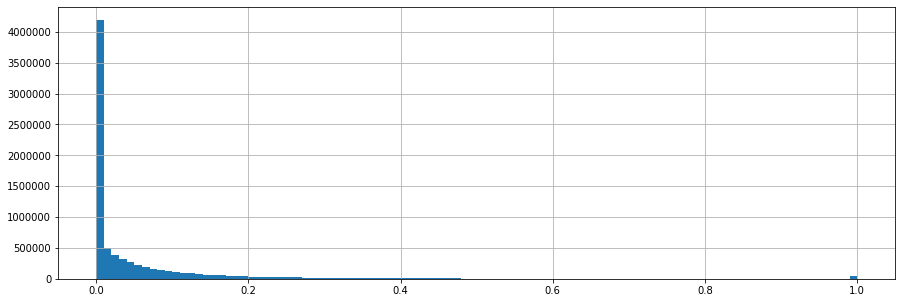

In [95]:
fig = plt.figure(figsize = (15,5))

supervised.demand.hist(bins=100)

* There are huge amounts of 0, leaving them out or setting a min percentile threshold is an experimentation idea.

# Preparing the data for modelling 

In [96]:
#supervised = pd.read_csv('processed_data/supervised.csv')
#full_set.to_csv('processed_data/full_set.csv',index=False)

In [97]:
full_set = extract_time(traffic_full_zero).merge(supervised,how='right',on=['geohash6','day','hour_day','min_hour','demand'])

In [98]:
del supervised, traffic

# Day 18 Outlier removal by using only day 30 onwards for model building  

* We can remove all data before day 31 the avoid the huge drops on day 18, and to save modelling time 

In [99]:
full_set_no_out = full_set[full_set.day > 30]
del full_set

In [100]:
full_set_no_out.head()

day_week  hour_day  min_hour geohash6  day timestamp  demand  demand+1  \
2880         3         0         0   qp02yc   31      00:0     0.0       0.0   
2881         3         0        15   qp02yc   31     00:15     0.0       0.0   
2882         3         0        30   qp02yc   31     00:30     0.0       0.0   
2883         3         0        45   qp02yc   31     00:45     0.0       0.0   
2884         3         1         0   qp02yc   31      01:0     0.0       0.0   

      demand+2  demand+3  demand+4  demand+5  
2880       0.0       0.0       0.0       0.0  
2881       0.0       0.0       0.0       0.0  
2882       0.0       0.0       0.0       0.0  
2883       0.0       0.0       0.0       0.0  
2884       0.0       0.0       0.0       0.0

In [101]:
preprocess(full_set_no_out.head(),p_add_geo_latlon=True)

day_week  hour_day  min_hour  day  demand  demand+1  demand+2  demand+3  \
0         3         0         0   31     0.0       0.0       0.0       0.0   
1         3         0        15   31     0.0       0.0       0.0       0.0   
2         3         0        30   31     0.0       0.0       0.0       0.0   
3         3         0        45   31     0.0       0.0       0.0       0.0   
4         3         1         0   31     0.0       0.0       0.0       0.0   

   demand+4  demand+5  latitude  longitude  geo_encoded  
0       0.0       0.0 -5.484924  90.653687            0  
1       0.0       0.0 -5.484924  90.653687            0  
2       0.0       0.0 -5.484924  90.653687            0  
3       0.0       0.0 -5.484924  90.653687            0  
4       0.0       0.0 -5.484924  90.653687            0

# Baseline Modeling 

## Naive forecast: use the current value as the forecast for the next interval 

In [102]:
class Naive():
    
    def __init__(self):
        self.data = None
        
    def predict(self,data):
        self.data = data.demand
    
        predictions =  np.array([]).reshape(0,5)
        
        if isinstance(self.data, (int, float, complex)):
            predictions =  np.vstack([predictions,np.array([self.data]*5)])   
        else:
            for row in self.data:
                predictions = np.vstack([predictions,np.array([row]*5)])
        
        return predictions

In [103]:
data = preprocess(full_set_no_out,p_add_geo_latlon=True)

future_demands = ['demand+1','demand+2','demand+3','demand+4','demand+5']

y = data[future_demands] 
X = data.drop(future_demands,axis=1)

In [104]:
X.head()
X.shape
y.head()
y.shape

day_week  hour_day  min_hour  day  demand  latitude  longitude  geo_encoded
0         3         0         0   31     0.0 -5.484924  90.653687            0
1         3         0        15   31     0.0 -5.484924  90.653687            0
2         3         0        30   31     0.0 -5.484924  90.653687            0
3         3         0        45   31     0.0 -5.484924  90.653687            0
4         3         1         0   31     0.0 -5.484924  90.653687            0

(3955104, 8)

demand+1  demand+2  demand+3  demand+4  demand+5
0       0.0       0.0       0.0       0.0       0.0
1       0.0       0.0       0.0       0.0       0.0
2       0.0       0.0       0.0       0.0       0.0
3       0.0       0.0       0.0       0.0       0.0
4       0.0       0.0       0.0       0.0       0.0

(3955104, 5)

In [105]:
# stratify so model trains on not just a few geohashes
# train % set high to reduce Naive model prediction time
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.99, stratify=X['geo_encoded'],random_state=4) 

In [106]:
preds = Naive().predict(X_test)

def rmse(y_test, preds):
    return np.sqrt(mean_squared_error(y_test, preds))

naive_err = rmse(y_test, preds)
print(naive_err)

0.03868002514998816


* We see that the Naive Forecast has a RMSE of 0.055, we will aim to build more models that can beat this

# RandomForestRegressor (has multi-output function)

## max_depth = 2, n_estimators = 10 

In [107]:
max_depth = 2
n_estimators = 10

client = Client(n_workers=1,threads_per_worker=10,processes=False)

with parallel_backend('dask'):
    
    from sklearn.ensemble import RandomForestRegressor

    reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,random_state=0)
    reg.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [108]:
rf_2_10_err = rmse(y_test,reg.predict(X_test))
print(rf_2_10_err)

0.05137304626352329


* This is worse than naive forecast. Lets try to change the train_test_split percentages and repeat the above, since rf should predict much faster than Naive so test set can be bigger

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=X['geo_encoded'],random_state=4) 

In [110]:
max_depth = 2
n_estimators = 10

client = Client(n_workers=1,threads_per_worker=10,processes=False)

with parallel_backend('dask'):
    
    from sklearn.ensemble import RandomForestRegressor

    reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,random_state=0)
    reg.fit(X_train,y_train)
    
rf_2_10_err = rmse(y_test,reg.predict(X_test))
print(rf_2_10_err)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

0.0513190617180399


## n_estimators  = 30

In [111]:
max_depth = 2
n_estimators = 30

client = Client(n_workers=1,threads_per_worker=10,processes=False)

with parallel_backend('dask'):
    
    from sklearn.ensemble import RandomForestRegressor

    reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,random_state=0)
    reg.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [112]:
rf_2_30_err = rmse(y_test,reg.predict(X_test))
print(rf_2_30_err)

0.05115243261804093


## max_depth = 10, n_estimators = 30 

In [113]:
max_depth = 10
n_estimators = 30

client = Client(n_workers=1,threads_per_worker=10,processes=False)

with parallel_backend('dask'):
    
    from sklearn.ensemble import RandomForestRegressor

    reg_10_30 = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,random_state=0)
    reg_10_30.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
rf_10_30_err = rmse(y_test,reg_10_30.predict(X_test))
print(rf_10_30_err)

* Increasing max_depth 2-->10 dropped RMSE 6% to 4%

### Saving the reg_10_30 model 

In [ ]:
joblib.dump(reg_10_30, 'reg_10_30.pkl') 

## max_depth = 10, n_estimators = 30, min_samples_leaf = 10000

In [ ]:
max_depth = 10
n_estimators = 30
min_samples_leaf = 10000


client = Client(n_workers=1,threads_per_worker=10,processes=False)

with parallel_backend('dask'):
    
    from sklearn.ensemble import RandomForestRegressor

    reg_10_30_10000 = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf = min_samples_leaf, random_state=0)
    reg_10_30_10000.fit(X_train,y_train)

In [ ]:
reg_10_30_10000_err = rmse(y_test,reg_10_30_10000.predict(X_test))
print(reg_10_30_10000_err)

## max_depth = 2, n_estimators = 10,  min_samples_leaf=100

In [ ]:
max_depth = 2
n_estimators = 10
min_samples_leaf = 100

client = Client(n_workers=1,threads_per_worker=10,processes=False)

with parallel_backend('dask'):
    
    from sklearn.ensemble import RandomForestRegressor

    reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf = min_samples_leaf, random_state=0)
    reg.fit(X_train,y_train)

In [ ]:
rf_2_10_100_err = rmse(y_test,reg.predict(X_test))
print(rf_2_10_100_err)

## max_depth = 20, n_estimators = 10 , min_samples_leaf = 1

In [ ]:
max_depth = 20
n_estimators = 10
min_samples_leaf = 1

client = Client(n_workers=1,threads_per_worker=10,processes=False)

with parallel_backend('dask'):
    
    from sklearn.ensemble import RandomForestRegressor

    reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf = min_samples_leaf, random_state=0)
    reg.fit(X_train,y_train)

In [ ]:
rf_20_10_100_err = rmse(y_test,reg.predict(X_test))
print(rf_2_10_100_err)

# Training with more features and preparing test set for prediction

In [ ]:
X_train_featured = preprocess(X_train,p_add_geo_latlon=True,p_add_geo_stats=True,p_add_time_stats=True)

In [ ]:
X_train_featured.isnull().sum()

In [ ]:
X_test_featured = preprocess(X_test,p_add_geo_latlon=True,p_add_geo_stats=True,p_add_time_stats=True)

In [ ]:
max_depth = 2
n_estimators = 10

client = Client(n_workers=1,threads_per_worker=10,processes=False)

with parallel_backend('dask'):
    
    from sklearn.ensemble import RandomForestRegressor

    reg_2_10 = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,random_state=0)
    reg_2_10.fit(X_train_featured,y_train)

In [ ]:
rf_2_10_err = rmse(y_test,reg_2_10.predict(X_test_featured))
print(rf_2_10_err)

* Too many features do not help, the vanilla regression tree will do  

# Prediction on Test Set from Grab 

In [ ]:
# test_from_grab = insert your test df here  

X_test_grab = preprocess(test_from_grab,p_add_geo_latlon=True,p_extract_time=True)

test_rf = joblib.load('reg_10_30.pkl')

# preds is a n by 5 array outputting all 5 time steps at once
preds = test_rf.predict(X_testing)

test_grab_err = rmse(y_test_grab, preds)
print(test_grab_err)